## Introduction

A simple Recurrent Neural Network (RNN) displays a strong inductive bias towards learning **temporally compressed representations**. **Equation 1** shows the recurrence formula, where `h_t` is the compressed representation (a single vector) of the entire input sequence `x`.

| ![Equation of RNN](https://i.imgur.com/Kdyj2jr.png) |
| :--: |
| **Equation 1**: The recurrence equation. (Source: Aritra and Suvaditya)|

On the other hand, Transformers ([Vaswani et. al](https://arxiv.org/abs/1706.03762)) have little inductive bias towards learning temporally compressed representations. It has achieved SoTA results in Natural Language Processing (NLP) and Vision tasks with its pair-wise attention mechanism.

While the Transformer has the ability to **attend** to different sections of the input sequence, the computation of attention is quadratic in nature.

[Didolkar et. al](https://arxiv.org/abs/2205.14794) argue that having a more compressed representation of a sequence may be beneficial for *generalization*, as it can be easily **re-used** and **re-purposed** with fewer irrelevant details. While compression is good, they also notice that too much of it can harm expressiveness.

The authors propose a solution that divides computation into **two streams**. A *slow stream* that is recurrent in nature and a *fast stream* that is parameterized as a Transformer. While this method has the novelty of introducing different processing streams in order to preserve and process latent states, it has parallels drawn in other works like the [Perceiver Mechanism (by Jaegle et. al.)](https://arxiv.org/abs/2103.03206) and [Grounded Language Learning Fast and Slow (by Hill et. al.)](https://arxiv.org/pdf/2009.01719.pdf).

The following example explores how we can make use of the new Temporal Latent Bottleneck mechanism to perform image classification on the CIFAR-10 dataset. We implement this model by making a custom `RNNCell` implementation in order to make a **performant** and **vectorized** design.

_Note_: This example makes use of `TensorFlow 2.11.0`, which must be installed into our system

## Setup imports

In [ ]:
!pip install -q tensorflow==2.11.0

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import mixed_precision
from tensorflow.keras.optimizers.experimental import AdamW

import random
from typing import Tuple, List
from matplotlib import pyplot as plt

# Set seed for reproducibility.
tf.keras.utils.set_random_seed(42)

AUTO = tf.data.AUTOTUNE

## Setting required configuration

We set a few configuration parameters that are needed within the pipeline we have designed. The current parameters are for use with the [CIFAR10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html).


The model also supports `mixed-precision` settings, which would quantize the model to use `16-bit` float numbers where it can, while keeping some parameters in `32-bit` as needed for numerical stability. This brings performance benefits as the footprint of the model decreases significantly while bringing speed boosts at inference-time.

In [ ]:
config = {
    "mixed_precision": True,
    "dataset": "cifar10",
    "train_slice": 40_000,
    "batch_size": 2048,
    "buffer_size": 2048 * 2,
    "input_shape": [32, 32, 3],
    "image_size": 48,
    "num_classes": 10,
    "learning_rate": 1e-4,
    "weight_decay": 1e-4,
    "epochs": 50,
    "patch_size": 4,
    "embed_dim": 64,
    "chunk_size": 8,
    "r": 2,
    "num_layers": 4,
    "ffn_drop": 0.2,
    "attn_drop": 0.2,
    "num_heads": 1,
}

if config["mixed_precision"]:
    policy = mixed_precision.Policy("mixed_float16")
    mixed_precision.set_global_policy(policy)

## Loading the CIFAR-10 dataset

We are going to use the CIFAR10 dataset for running our experiments. This dataset contains a training set of `50,000` images for `10` classes with the standard image size of `(32, 32, 3)`.

It also has a separate set of `10,000` images with similar characteristics. More information about the dataset may be found at the official site for the dataset as well as [`keras.datasets.cifar10`](https://keras.io/api/datasets/cifar10/) API reference

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
(x_train, y_train), (x_val, y_val) = (
    (x_train[: config["train_slice"]], y_train[: config["train_slice"]]),
    (x_train[config["train_slice"] :], y_train[config["train_slice"] :]),
)

170498071/170498071 [==============================] - 3s 0us/step


## Define Augmentation pipelines for Train and Validation/Test pipelines

We define separate pipelines for performing image augmentation on our data. This step is important in pre-processing the data, making the model more robust to changes, helping it to generalize better. The steps we perform are as follows:

- `Rescaling` (Training, Test): This step is performed to normalize all image pixel values from the [0,255] range to [0,1). This helps in maintaining numerical stability later ahead during training.

- `Resizing` (Training, Test): We resize the image from it's original size of (32, 32) to (52, 52). This is done to account for the Random Crop, as well as comply with the specifications of the data given in the paper.

- `RandomCrop` (Training): This layer will randomly select a crop/sub-region of the image with size (48, 48).

- `RandomFlip` (Training): This layer will randomly flip all the images horizontally, keeping sizes same.

In [ ]:
# Build the `train` augmentation pipeline.
train_aug = keras.Sequential(
    [
        layers.Rescaling(1 / 255.0, dtype="float32"),
        layers.Resizing(
            config["input_shape"][0] + 20,
            config["input_shape"][0] + 20,
            dtype="float32",
        ),
        layers.RandomCrop(config["image_size"], config["image_size"], dtype="float32"),
        layers.RandomFlip("horizontal", dtype="float32"),
    ],
    name="train_data_augmentation",
)

# Build the `val` and `test` data pipeline.
test_aug = keras.Sequential(
    [
        layers.Rescaling(1 / 255.0, dtype="float32"),
        layers.Resizing(config["image_size"], config["image_size"], dtype="float32"),
    ],
    name="test_data_augmentation",
)

# We define functions in place of simple lambda functions to run through the
# `keras.Sequential`in order to solve this warning:
# (https://github.com/tensorflow/tensorflow/issues/56089)

def train_map_fn(image, label):
    return train_aug(image), label

def test_map_fn(image, label):
    return test_aug(image), label

## Load dataset into `tf.data.Dataset` object

- We take the `np.ndarray` instance of the datasets and move them into a `tf.data.Dataset` instance
- Apply augmentations using [`.map()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map)
- Shuffle the dataset using [`.shuffle()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle)
- Batch the dataset using [`.batch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch)
- Enable pre-fetching of batches using [`.prefetch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch)

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = (
    train_ds.map(train_map_fn, num_parallel_calls=AUTO)
    .shuffle(config["buffer_size"])
    .batch(config["batch_size"], num_parallel_calls=AUTO)
    .prefetch(AUTO)
)

val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_ds = (
    val_ds.map(test_map_fn, num_parallel_calls=AUTO)
    .batch(config["batch_size"], num_parallel_calls=AUTO)
    .prefetch(AUTO)
)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_ds = (
    test_ds.map(test_map_fn, num_parallel_calls=AUTO)
    .batch(config["batch_size"], num_parallel_calls=AUTO)
    .prefetch(AUTO)
)

## Temporal Latent Bottleneck

An excerpt from the paper:

> In the brain, short-term and long-term memory have developed in a specialized way. Short-term memory is allowed to change very quickly to react to immediate sensory inputs and perception. By contrast, long-term memory changes slowly, is highly selective and involves repeated consolidation.

Inspired from the short-term and long-term memory the authors introduce the fast stream and slow stream computation. The fast stream has a short-term memory with a high capacity that reacts quickly to sensory input (Transformers). The slow stream has long-term memory which updates at a slower rate and summarizes the most relevant information (Recurrence).

To implement this idea we need to:

- Take a sequence of data.
- Divide the sequence into fixed-size chunks.
- Fast stream operates within each chunk. It provides fine-grained local information.
- Slow stream consolidates and aggregates information across chunks. It provides coarse-grained distant information.

The fast and slow stream induce what is called **information asymmetry**. The two streams interact with each other through a bottleneck of attention. **Figure 1** shows the architecture of the model.

| ![Architecture of the model](https://i.imgur.com/bxdLPNH.png) |
| :--: |
| Figure 1: Architecture of the model. (Source: https://arxiv.org/abs/2205.14794) |

A PyTorch-style pseudocode is also proposed by the authors as shown in **Algorithm 1**.

| ![Pseudocode of the model](https://i.imgur.com/s8a5Vz9.png) |
| :--: |
| Algorithm 1: PyTorch styled pseudocode. (Source: https://arxiv.org/abs/2205.14794) |


### `PatchEmbed` layer

This custom `keras.layers.Layer` is useful for generating patches from the image and transform them into a higher-dimensional embedding space using `keras.layers.Embedding`. The patching operation is done using a `keras.layers.Conv2D` instance instead of a traditional `tf.image.extract_patches` to allow for vectorization.  

Once the patching of images is complete, we reshape the image patches in order to get a flattened representation where the number of dimensions is the embedding dimension. At this stage, we also inject positional information to the tokens.

After we obtain the tokens we chunk them. The chunking operation involves taking fixed-size sequences from the embedding output to create 'chunks', which will then be used as the final input to the model.

In [ ]:
class PatchEmbed(layers.Layer):
    """Image to Patch Embedding.
    Args:
        image_size (`Tuple[int]`): Size of the input image.
        patch_size (`Tuple[int]`): Size of the patch.
        embed_dim (`int`): Dimension of the embedding.
        chunk_size (`int`): Number of patches to be chunked.
    """

    def __init__(
        self,
        image_size: Tuple[int],
        patch_size: Tuple[int],
        embed_dim: int,
        chunk_size: int,
        **kwargs,
    ):
        super().__init__(**kwargs)

        # Compute the patch resolution.
        patch_resolution = [
            image_size[0] // patch_size[0],
            image_size[1] // patch_size[1],
        ]

        # Store the parameters.
        self.image_size = image_size
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.patch_resolution = patch_resolution
        self.num_patches = patch_resolution[0] * patch_resolution[1]

        # Define the positions of the patches.
        self.positions = tf.range(start=0, limit=self.num_patches, delta=1)

        # Create the layers.
        self.projection = layers.Conv2D(
            filters=embed_dim,
            kernel_size=patch_size,
            strides=patch_size,
            name="projection",
        )
        self.flatten = layers.Reshape(
            target_shape=(-1, embed_dim),
            name="flatten",
        )
        self.position_embedding = layers.Embedding(
            input_dim=self.num_patches,
            output_dim=embed_dim,
            name="position_embedding",
        )
        self.layernorm = keras.layers.LayerNormalization(
            epsilon=1e-5,
            name="layernorm",
        )
        self.chunking_layer = layers.Reshape(
            target_shape=(self.num_patches // chunk_size, chunk_size, embed_dim),
            name="chunking_layer",
        )

    def call(self, inputs: tf.Tensor) -> Tuple[tf.Tensor, int, int, int]:
        """Call function.
        Args:
            inputs (`tf.Tensor`): Input tensor.
        Returns:
            `Tuple[tf.Tensor, int, int, int]`: Tuple of the projected input, number of patches,
                patch resolution, and embedding dimension.
        """
        # Project the inputs to the embedding dimension.
        x = self.projection(inputs)

        # Flatten the pathces and add position embedding.
        x = self.flatten(x)
        x = x + self.position_embedding(self.positions)

        # Normalize the embeddings.
        x = self.layernorm(x)

        # Chunk the tokens.
        x = self.chunking_layer(x)

        return x

### `FeedForwardNetwork` Layer

This custom `keras.layers.Layer` instance allows us to define a generic FFN along with a dropout.

In [ ]:
class FeedForwardNetwork(layers.Layer):
    """Feed Forward Network.
    Args:
        dims (`int`): Number of units in FFN.
        dropout (`float`): Dropout probability for FFN.
    """

    def __init__(self, dims: int, dropout: float, **kwargs):
        super().__init__(**kwargs)

        # Create the layers.
        self.ffn = keras.Sequential(
            [
                layers.Dense(units=4 * dims, activation=tf.nn.gelu),
                layers.Dense(units=dims),
                layers.Dropout(rate=dropout),
            ],
            name="ffn",
        )
        self.add = layers.Add(
            name="add",
        )
        self.layernorm = layers.LayerNormalization(
            epsilon=1e-5,
            name="layernorm",
        )

    def call(self, inputs: tf.Tensor) -> tf.Tensor:
        """Call function.
        Args:
            inputs (`tf.Tensor`): Input tensor.
        Returns:
            `tf.Tensor`: Output tensor."""
        # Apply the FFN.
        x = self.layernorm(inputs)
        x = self.add([inputs, self.ffn(x)])
        return x

### `BaseAttention` layer

This custom `keras.layers.Layer` instance is a `super`/`base` class that wraps a `keras.layers.MultiHeadAttention` layer along with some other components. This gives us basic common denominator functionality for all the Attention layers/modules in our model.

In [ ]:
class BaseAttention(layers.Layer):
    """Base Attention Module.
    Args:
        num_heads (`int`): Number of attention heads.
        key_dim (`int`): Size of each attention head for key.
        dropout (`float`): Dropout probability for attention module.
    """

    def __init__(self, num_heads: int, key_dim: int, dropout: float, **kwargs):
        super().__init__(**kwargs)
        self.mha = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=key_dim,
            dropout=dropout,
            name="mha",
        )
        self.q_layernorm = layers.LayerNormalization(
            epsilon=1e-5,
            name="q_layernorm",
        )
        self.k_layernorm = layers.LayerNormalization(
            epsilon=1e-5,
            name="k_layernorm",
        )
        self.v_layernorm = layers.LayerNormalization(
            epsilon=1e-5,
            name="v_layernorm",
        )
        self.add = layers.Add(
            name="add",
        )

        self.attn_scores = None

    def call(
        self, input_query: tf.Tensor, key: tf.Tensor, value: tf.Tensor
    ) -> tf.Tensor:
        """Call function.
        Args:
            input_query (`tf.Tensor`): Input query tensor.
            key (`tf.Tensor`): Key tensor.
            value (`tf.Tensor`): Value tensor.
        Returns:
            `tf.Tensor`: Output tensor."""
        # Apply the attention module.
        query = self.q_layernorm(input_query)
        key = self.k_layernorm(key)
        value = self.v_layernorm(value)
        (attn_outs, attn_scores) = self.mha(
            query=query,
            key=key,
            value=value,
            return_attention_scores=True,
        )

        # Save the attention scores for later visualization.
        self.attn_scores = attn_scores

        # Add the input to the attention output.
        x = self.add([input_query, attn_outs])
        return x

### `Attention` with `FeedForwardNetwork` layer

This custom `keras.layers.Layer` implementation combines the `BaseAttention` and `FeedForwardNetwork` components to develop one block which will be used repeatedly within the model. This module is highly customizable and flexible, allowing for changes within the internal layers.

In [ ]:
class AttentionWithFFN(layers.Layer):
    """Attention with Feed Forward Network.
    Args:
        ffn_dims (`int`): Number of units in FFN.
        ffn_dropout (`float`): Dropout probability for FFN.
        num_heads (`int`): Number of attention heads.
        key_dim (`int`): Size of each attention head for key.
        attn_dropout (`float`): Dropout probability for attention module.
    """

    def __init__(
        self,
        ffn_dims: int,
        ffn_dropout: float,
        num_heads: int,
        key_dim: int,
        attn_dropout: float,
        **kwargs,
    ):
        super().__init__(**kwargs)
        # Create the layers.
        self.attention = BaseAttention(
            num_heads=num_heads,
            key_dim=key_dim,
            dropout=attn_dropout,
            name="base_attn",
        )
        self.ffn = FeedForwardNetwork(
            dims=ffn_dims,
            dropout=ffn_dropout,
            name="ffn",
        )

        self.attn_scores = None

    def call(self, query: tf.Tensor, key: tf.Tensor, value: tf.Tensor) -> tf.Tensor:
        """Call function.
        Args:
            query (`tf.Tensor`): Input query tensor.
            key (`tf.Tensor`): Key tensor.
            value (`tf.Tensor`): Value tensor.
        Returns:
            `tf.Tensor`: Output tensor.
        """
        # Apply the attention module.
        x = self.attention(query, key, value)

        # Save the attention scores for later visualization.
        self.attn_scores = self.attention.attn_scores

        # Apply the FFN.
        x = self.ffn(x)
        return x

### Custom RNN Cell for **Temporal Latent Bottleneck** and **Perceptual Module**

**Algorithm 1** (the pseudocode) depicts recurrence with the help of for loops. Looping does make the implementation simpler, harming the training time. In this section we wrap the custom recurrence logic inside of the `CustomRecurrentCell`. This custom cell will then be wrapped with the [Keras RNN API](https://keras.io/api/layers/recurrent_layers/rnn/) that makes the entire code vectorizable.

This custom cell, implemented as a `keras.layers.Layer`, is the integral part of the logic for the model.
The cell's functionality can be divided into 2 parts:
- **Slow Stream (Temporal Latent Bottleneck):**

    - This module consists of a single `AttentionWithFFN` layer that parses the output of the previous Slow Stream, an intermediate hidden representation (which is the *latent* in Temporal Latent Bottleneck) as the Query, and the output of the latest Fast Stream as Key and Value. This layer can also be construed as a *CrossAttention* layer.

- **Fast Stream (Perceptual Module):**
    
    - This module consists of intertwined `AttentionWithFFN` layers. This stream consists of *n* layers of `SelfAttention` and `CrossAttention` in a sequential manner. 
    - Here, some layers take the chunked input as the Query, Key and Value (Also referred to as the *SelfAttention* layer). 
    - The other layers take the intermediate state outputs from within the Temporal Latent Bottleneck module as the Query while using the output of the previous Self-Attention layers before it as the Key and Value.

In [ ]:
class CustomRecurrentCell(layers.Layer):
    """Custom Recurrent Cell.
    Args:
        chunk_size (`int`): Number of tokens in a chunk.
        r (`int`): One Cross Attention per **r** Self Attention.
        num_layers (`int`): Number of layers.
        ffn_dims (`int`): Number of units in FFN.
        ffn_dropout (`float`): Dropout probability for FFN.
        num_heads (`int`): Number of attention heads.
        key_dim (`int`): Size of each attention head for key.
        attn_dropout (`float`): Dropout probability for attention module.
    """

    def __init__(
        self,
        chunk_size: int,
        r: int,
        num_layers: int,
        ffn_dims: int,
        ffn_dropout: float,
        num_heads: int,
        key_dim: int,
        attn_dropout: float,
        **kwargs,
    ):
        super().__init__(**kwargs)
        # Save the arguments.
        self.chunk_size = chunk_size
        self.r = r
        self.num_layers = num_layers
        self.ffn_dims = ffn_dims
        self.ffn_droput = ffn_dropout
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.attn_dropout = attn_dropout

        # Create the state_size and output_size. This is important for
        # custom recurrence logic.
        self.state_size = tf.TensorShape([chunk_size, ffn_dims])
        self.output_size = tf.TensorShape([chunk_size, ffn_dims])

        self.get_attn_scores = False
        self.attn_scores = []

        ########################################################################
        # Perceptual Module
        ########################################################################
        perceptual_module = list()
        for layer_idx in range(num_layers):
            perceptual_module.append(
                AttentionWithFFN(
                    ffn_dims=ffn_dims,
                    ffn_dropout=ffn_dropout,
                    num_heads=num_heads,
                    key_dim=key_dim,
                    attn_dropout=attn_dropout,
                    name=f"pm_self_attn_{layer_idx}",
                )
            )
            if layer_idx % r == 0:
                perceptual_module.append(
                    AttentionWithFFN(
                        ffn_dims=ffn_dims,
                        ffn_dropout=ffn_dropout,
                        num_heads=num_heads,
                        key_dim=key_dim,
                        attn_dropout=attn_dropout,
                        name=f"pm_cross_attn_ffn_{layer_idx}",
                    )
                )
        self.perceptual_module = perceptual_module

        ########################################################################
        # Temporal Latent Bottleneck Module
        ########################################################################
        self.tlb_module = AttentionWithFFN(
            ffn_dims=ffn_dims,
            ffn_dropout=ffn_dropout,
            num_heads=num_heads,
            key_dim=key_dim,
            attn_dropout=attn_dropout,
            name=f"tlb_cross_attn_ffn",
        )

    def call(self, inputs, states) -> Tuple[tf.Tensor, List[tf.Tensor]]:
        """Call function.
        Args:
            inputs (`tf.Tensor`): Input tensor.
            states (`List[tf.Tensor]`): List of state tensors.
        Returns:
            `Tuple[tf.Tensor, List[tf.Tensor]]`: Tuple of output tensor and list
                of state tensors.
        """
        # inputs => (batch, chunk_size, dims)
        # states => [(batch, chunk_size, units)]
        slow_stream = states[0]
        fast_stream = inputs

        for layer_idx, layer in enumerate(self.perceptual_module):
            fast_stream = layer(query=fast_stream, key=fast_stream, value=fast_stream)

            if layer_idx % self.r == 0:
                fast_stream = layer(
                    query=fast_stream, key=slow_stream, value=slow_stream
                )

        slow_stream = self.tlb_module(
            query=slow_stream, key=fast_stream, value=fast_stream
        )

        # Save the attention scores for later visualization.
        if self.get_attn_scores:
            self.attn_scores.append(self.tlb_module.attn_scores)

        return fast_stream, [slow_stream]

### `ModelTrainer` to encapsulate full model

Here, we just wrap the full model as to expose it for training.

In [ ]:
class ModelTrainer(keras.Model):
    """Model Trainer.
    Args:
        patch_layer (`tf.keras.layers.Layer`): Patching layer.
        custom_cell (`tf.keras.layers.Layer`): Custom Recurrent Cell.
    """

    def __init__(self, patch_layer, custom_cell, **kwargs):
        super().__init__(**kwargs)
        self.patch_layer = patch_layer
        self.rnn = layers.RNN(custom_cell, name="rnn")
        self.gap = layers.GlobalAveragePooling1D(name="gap")
        self.head = layers.Dense(10, activation="softmax", dtype="float32", name="head")

    def call(self, inputs: tf.Tensor) -> tf.Tensor:
        """Call function.
        Args:
            inputs (`tf.Tensor`): Input tensor.
        Returns:
            `tf.Tensor`: Output tensor.
        """
        x = self.patch_layer(inputs)
        x = self.rnn(x)
        x = self.gap(x)
        outputs = self.head(x)
        return outputs

## Build the model

To begin training, we now define the components individually and pass them as arguments to our wrapper class, which will prepare the final model for training. We define a `PatchEmbed` layer, and the `CustomCell`-based RNN.

In [ ]:
# We call this to clear all previous session states. This frees up GPU memory
# consumption as well.

keras.backend.clear_session()

# Build the model.
patch_layer = PatchEmbed(
    image_size=(config["image_size"], config["image_size"]),
    patch_size=(config["patch_size"], config["patch_size"]),
    embed_dim=config["embed_dim"],
    chunk_size=config["chunk_size"],
)
custom_rnn_cell = CustomRecurrentCell(
    chunk_size=config["chunk_size"],
    r=config["r"],
    num_layers=config["num_layers"],
    ffn_dims=config["embed_dim"],
    ffn_dropout=config["ffn_drop"],
    num_heads=config["num_heads"],
    key_dim=config["embed_dim"],
    attn_dropout=config["attn_drop"]
)
model = ModelTrainer(patch_layer=patch_layer, custom_cell=custom_rnn_cell)

## Metrics and Callbacks

We use the `AdamW` optimizer from `tf.keras.optimizers.experimental` (previously part of `tensorflow-addons`) since it has been shown to perform very well on several benchmark tasks from an optimization perspective. It is a version of the `tf.keras.optimizers.Adam` optimizer, along with Weight Decay in place.

For a loss function, we make use of the `keras.losses.SparseCategoricalCrossentropy` function that makes use of simple Cross-entropy between prediction and actual logits. We also calculate accuracy on our data as a sanity-check.

In [ ]:
optimizer = AdamW(
    learning_rate=config["learning_rate"], weight_decay=config["weight_decay"]
)
model.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

## Train the model with `model.fit()`

We pass the training dataset and run training.

In [ ]:
history = model.fit(
    train_ds,
    epochs=config["epochs"],
    validation_data=val_ds,
)

Epoch 1/50
20/20 [==============================] - 119s 2s/step - loss: 2.6308 - accuracy: 0.1025 - val_loss: 2.2832 - val_accuracy: 0.1252
Epoch 2/50
20/20 [==============================] - 28s 1s/step - loss: 2.2793 - accuracy: 0.1550 - val_loss: 2.1722 - val_accuracy: 0.1847
Epoch 3/50
20/20 [==============================] - 28s 1s/step - loss: 2.1992 - accuracy: 0.1867 - val_loss: 2.1287 - val_accuracy: 0.2249
Epoch 4/50
20/20 [==============================] - 28s 1s/step - loss: 2.1268 - accuracy: 0.2203 - val_loss: 2.0845 - val_accuracy: 0.2497
Epoch 5/50
20/20 [==============================] - 28s 1s/step - loss: 2.0652 - accuracy: 0.2375 - val_loss: 2.0134 - val_accuracy: 0.2666
Epoch 6/50
20/20 [==============================] - 28s 1s/step - loss: 2.0334 - accuracy: 0.2536 - val_loss: 2.0115 - val_accuracy: 0.2697
Epoch 7/50
20/20 [==============================] - 28s 1s/step - loss: 2.0080 - accuracy: 0.2596 - val_loss: 1.9810 - val_accuracy: 0.2845
Epoch 8/50
20/20 [=

## Visualize training metrics

The `model.fit()` will return a `history` object, which stores the values of the metrics generated during the training run (but it is ephemeral and needs to be saved manually).

We now display the Loss and Accuracy curves for the training and validation sets.

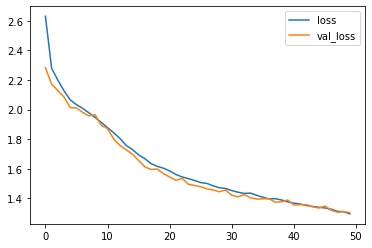

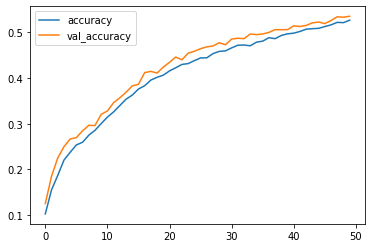

In [ ]:
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend()
plt.show()

plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.legend()
plt.show()

## Visualize attention maps from the Temporal Latent Bottleneck

Now that we have trained our model it is time for some visualizations. The Fast Stream (Transformers) processes a chunk of tokens. The Slow Stream processes each chunk and attends to tokens that are useful for the task.

In this section we will visualize the attention map of the Slow Stream. This is done by extracting the attention scores from the TLB layer at each chunk's intersection and storing it within the RNN's state. This is followed by 'ballooning' it up and returning these values.

In [ ]:
def score_to_viz(chunk_score):
    # get the most attended token
    chunk_viz = tf.math.reduce_max(chunk_score, axis=-2)
    # get the mean across heads
    chunk_viz = tf.math.reduce_mean(chunk_viz, axis=1)  
    return chunk_viz

# Get a batch of images and labels from the testing dataset
images, labels = next(iter(test_ds))

# Set the get_attn_scores flag to True
model.rnn.cell.get_attn_scores = True

# Run the model with the testing images and grab the
# attention scores.
outputs = model(images)
list_chunk_scores = model.rnn.cell.attn_scores

# Process the attention scores in order to visualize them
list_chunk_viz = [score_to_viz(x) for x in list_chunk_scores]
chunk_viz = tf.concat(list_chunk_viz[1:], axis=-1)
chunk_viz = tf.reshape(
    chunk_viz,
    (
        config["batch_size"],
        config["image_size"] // config["patch_size"],
        config["image_size"] // config["patch_size"],
        1,
    ),
)
upsampled_heat_map = layers.UpSampling2D(
    size=(4, 4), interpolation="bilinear", dtype="float32"
)(chunk_viz)

Run the following code snippet to get different images and their attention maps.

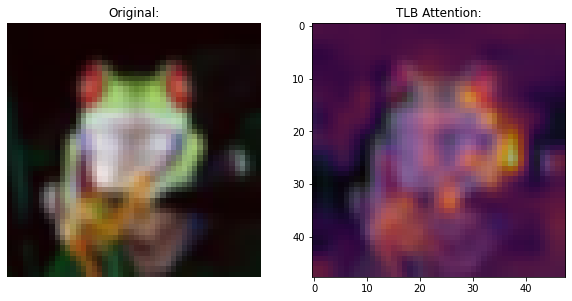

In [ ]:
# Sample a random image
index = random.randint(0, config["batch_size"])
orig_image = images[index]
overlay_image = upsampled_heat_map[index, ..., 0]

# Plot the visualization
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

ax[0].imshow(orig_image)
ax[0].set_title("Original:")
ax[0].axis("off")

image = ax[1].imshow(orig_image)
ax[1].imshow(
    overlay_image,
    cmap="inferno",
    alpha=0.6,
    extent=image.get_extent(),
)
ax[1].set_title("TLB Attention:")

plt.show()

## Conclusion

This example has hereby demonstrated an implementation of the Temporal Latent Bottleneck mechanism. The example highlights the use of compression and storage of historical states in the form of a Temporal Latent Bottleneck with regular updates from a Perceptual Module as an effective method to do so.

In the original paper, the authors have conducted highly extensive tests around different modalities ranging from Supervised Image Classification to applications in Reinforcement Learning.  

While we have only displayed a method to apply this mechanism to Image Classification, it can be extended to other modalities too with minimal changes.

*Note*: While building this example we did not have the official code to refer to. This means that our implementation is inspired from the paper with no claims of being a complete reproduction. For more details on the training process one can head over to [our GitHub repository](https://github.com/suvadityamuk/Temporal-Latent-Bottleneck-TF).

## Acknowledgement

We would like to thank [PyImageSearch](https://pyimagesearch.com/) for a Colab Pro account and [JarvisLabs.ai](https://cloud.jarvislabs.ai/) for GPU credits.